In [2]:
%matplotlib inline


# DS-CNN/KWS inference

This tutorial illustrates the process of developing an Akida-compatible speech recognition
model that can identify thirty-two different keywords.

Initially, the model is defined as a CNN in Keras and trained regularly. Next, it undergoes
quantization using [QuantizeML](../../user_guide/quantizeml.html)_ and finally converted
to Akida using [CNN2SNN](../../user_guide/cnn2snn.html)_.

This example uses a Keyword Spotting Dataset prepared using **TensorFlow** [audio recognition
example](https://www.tensorflow.org/tutorials/audio/simple_audio)_ utils.


## 1. Load the preprocessed dataset

The TensorFlow [speech_commands](https://www.tensorflow.org/datasets/catalog/speech_commands)_
dataset is used for training and validation. All keywords except "backward",
"follow" and "forward", are retrieved. These three words are kept to
illustrate the edge learning in this
[edge example](../edge/plot_1_edge_learning_kws.html)_.

The words to recognize have been converted to [spectrogram images](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md#how-does-this-model-work)_
that allows us to use a model architecture that is typically used for image recognition tasks.
The raw audio data have been preprocessed, transforming the audio files into MFCC features,
well-suited for CNN networks.
A pickle file containing the preprocessed data is available on Brainchip data server.




In [11]:
import pickle
import tensorflow as tf

from tensorflow.keras.utils import get_file

# Fetch pre-processed data for 32 keywords
fname = get_file(
    fname='kws_preprocessed_all_words_except_backward_follow_forward.pkl',
    origin="https://data.brainchip.com/dataset-mirror/kws/kws_preprocessed_all_words_except_backward_follow_forward.pkl",
    cache_subdir='datasets/kws')
with open(fname, 'rb') as f:
    [_, _, x_valid, y_valid, _, _, word_to_index, _] = pickle.load(f)

# Preprocessed dataset parameters
num_classes = len(word_to_index)

print("Wanted words and labels:\n", word_to_index)

Wanted words and labels:
 {'six': 23, 'three': 25, 'seven': 21, 'bed': 1, 'eight': 6, 'yes': 31, 'cat': 3, 'on': 18, 'one': 19, 'stop': 24, 'two': 27, 'house': 11, 'five': 7, 'down': 5, 'four': 8, 'go': 9, 'up': 28, 'learn': 12, 'no': 16, 'bird': 2, 'zero': 32, 'nine': 15, 'visual': 29, 'wow': 30, 'sheila': 22, 'marvin': 14, 'off': 17, 'right': 20, 'left': 13, 'happy': 10, 'dog': 4, 'tree': 26, '_silence_': 0}


## 2. Load a pre-trained native Keras model

The model consists of:

* a first convolutional layer accepting dense inputs (images),
* several separable convolutional layers preserving spatial dimensions,
* a global pooling reducing the spatial dimensions to a single pixel,
* a final dense layer to classify words.

All layers are followed by a batch normalization and a ReLU activation.




In [15]:
from tensorflow.keras.models import load_model

# Retrieve the model file from the BrainChip data server
model_file = get_file("ds_cnn_kws.h5",
                      "https://data.brainchip.com/models/AkidaV2/ds_cnn/ds_cnn_kws.h5",
                      cache_subdir='models')

# Load the native Keras pre-trained model
model_keras = load_model(model_file)
model_keras.summary()
tf.keras.utils.plot_model(model_keras, show_shapes=True)


Model: "ds_cnn_kws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49, 10, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 49, 10, 1)         0         
                                                                 
 conv_0 (Conv2D)             (None, 25, 5, 64)         1600      
                                                                 
 conv_0/BN (BatchNormalizati  (None, 25, 5, 64)        256       
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 25, 5, 64)         0         
                                                                 
 dw_separable_1 (DepthwiseCo  (None, 25, 5, 64)        576       
 nv2D)                                                  

In [5]:
import numpy as np

from sklearn.metrics import accuracy_score

# Check Keras Model performance
potentials_keras = model_keras.predict(x_valid)
preds_keras = np.squeeze(np.argmax(potentials_keras, 1))

accuracy = accuracy_score(y_valid, preds_keras)
print("Accuracy: " + "{0:.2f}".format(100 * accuracy) + "%")

308/308 [==============================] - 2s 6ms/step
Accuracy: 93.26%


## 3. Load a pre-trained quantized Keras model

The above native Keras model has been quantized to 8-bit. Note that
a 4-bit version is also available from the [model zoo](../../model_zoo_performance.html#id10).




In [13]:
from quantizeml.models import load_model

# Load the pre-trained quantized model
model_file = get_file(
    "ds_cnn_kws_i8_w8_a8.h5",
    "https://data.brainchip.com/models/AkidaV2/ds_cnn/ds_cnn_kws_i8_w8_a8.h5",
    cache_subdir='models')
model_keras_quantized = load_model(model_file)
model_keras_quantized.summary()


# Check Model performance
potentials_keras_q = model_keras_quantized.predict(x_valid)
preds_keras_q = np.squeeze(np.argmax(potentials_keras_q, 1))

accuracy_q = accuracy_score(y_valid, preds_keras_q)
print("Accuracy: " + "{0:.2f}".format(100 * accuracy_q) + "%")



Model: "ds_cnn_kws"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49, 10, 1)]       0         
                                                                 
 rescaling (QuantizedRescali  (None, 49, 10, 1)        0         
 ng)                                                             
                                                                 
 conv_0 (QuantizedConv2D)    (None, 25, 5, 64)         1664      
                                                                 
 conv_0/relu (QuantizedReLU)  (None, 25, 5, 64)        128       
                                                                 
 dw_separable_1 (QuantizedDe  (None, 25, 5, 64)        704       
 pthwiseConv2D)                                                  
                                                                 
 pw_separable_1 (QuantizedCo  (None, 25, 5, 64)        4

## 4. Conversion to Akida

The converted model is Akida 2.0 compatible and its performance
evaluation is done using the Akida simulator.




In [8]:
from cnn2snn import convert

# Convert the model
model_akida = convert(model_keras_quantized)
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[49, 10, 1]  [1, 1, 33]    1          11    
______________________________________________

________________________________________________________________
Layer (type)                      Output shape  Kernel shape  

=============== SW/conv_0-dequantizer (Software) ===============

conv_0 (InputConv2D)              [25, 5, 64]   (5, 5, 1, 64) 
________________________________________________________________
dw_separable_1 (DepthwiseConv2D)  [25, 5, 64]   (3, 3, 64, 1) 
________________________________________________________________
pw_separable_1 (Conv2D)           [25, 5, 64]   (1, 1, 64, 64)
________________________________________________________________
dw_separable_2 (DepthwiseConv2D)  [25, 5, 64]   (3, 3, 64, 1) 
________________________________________________________________
pw_separable_2 (Conv2D)           [25, 5, 64]   (1, 1, 64, 64

In [9]:
# Check Akida model performance
preds_akida = model_akida.predict_classes(x_valid, num_classes=num_classes)

accuracy = accuracy_score(y_valid, preds_akida)
print("Accuracy: " + "{0:.2f}".format(100 * accuracy) + "%")

# For non-regression purposes
assert accuracy > 0.9

Accuracy: 93.13%


## 5. Confusion matrix

The confusion matrix provides a good summary of what mistakes the
network is making.

Per scikit-learn convention it displays the true class in each row (ie
on each row you can see what the network predicted for the corresponding
word).

Please refer to the Tensorflow [audio
recognition](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md#confusion-matrix)_
example for a detailed explanation of the confusion matrix.




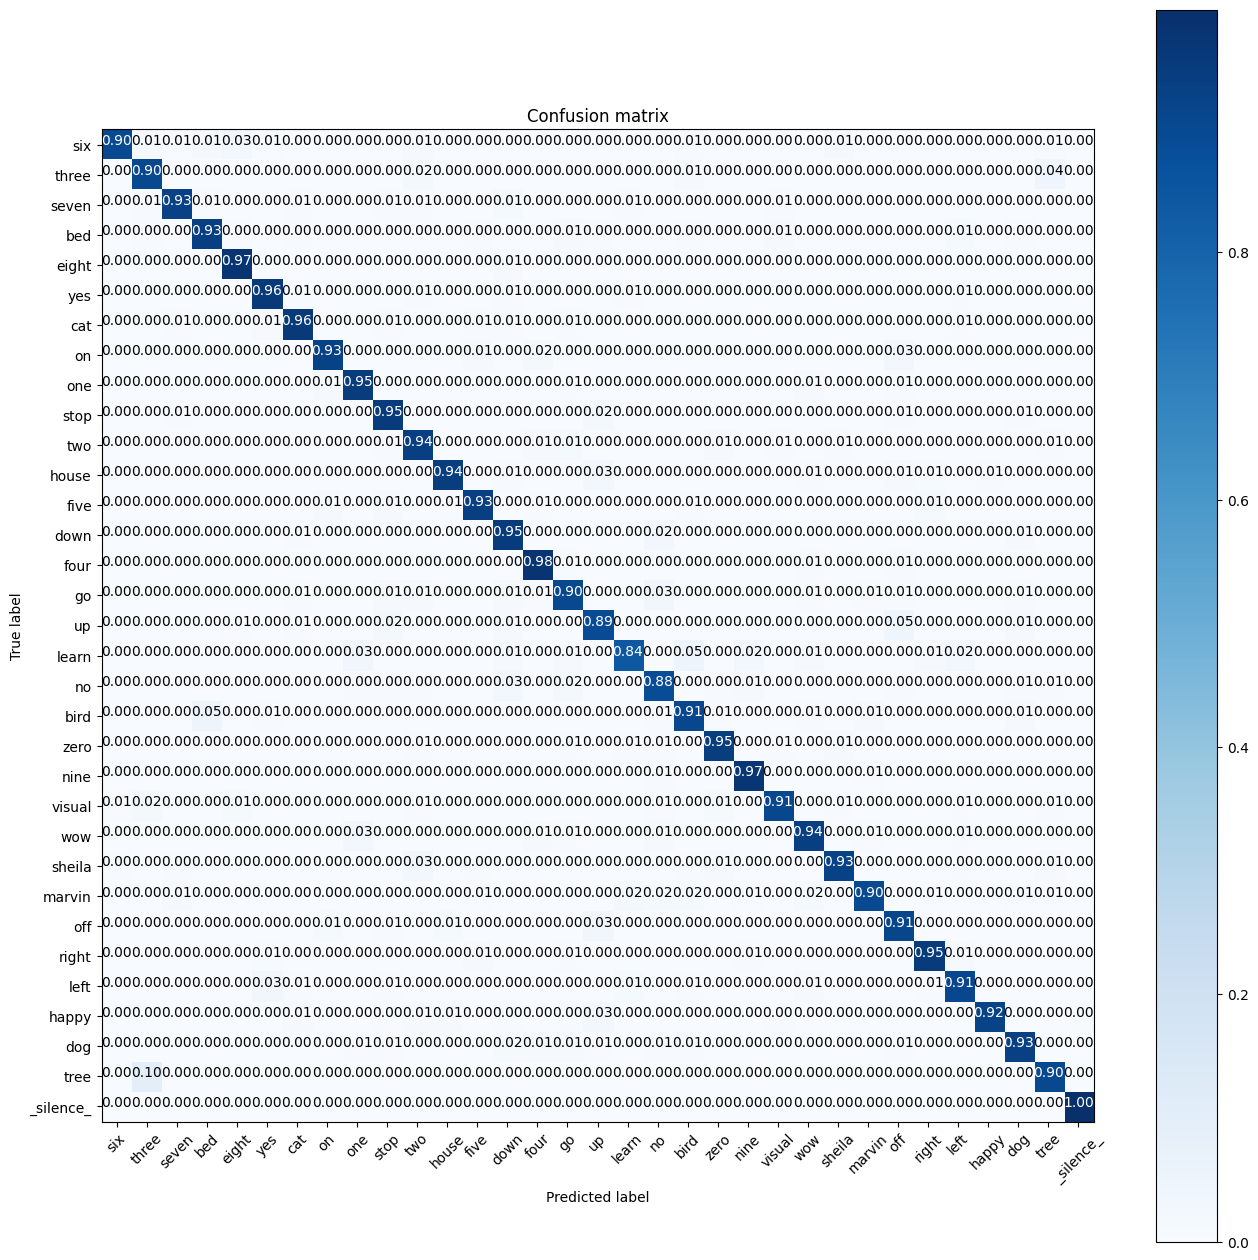

In [10]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_valid, preds_akida,
                      labels=list(word_to_index.values()))

# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display confusion matrix
plt.rcParams["figure.figsize"] = (16, 16)
plt.figure()

title = 'Confusion matrix'
cmap = plt.cm.Blues

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(word_to_index))
plt.xticks(tick_marks, word_to_index, rotation=45)
plt.yticks(tick_marks, word_to_index)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,
             i,
             format(cm[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.autoscale()
plt.show()